### Get tensorflow/models or cd to parent directory of the repository.

In [1]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2574, done.
remote: Counting objects: 100% (2574/2574), done.
remote: Compressing objects: 100% (2264/2264), done.
remote: Total 2574 (delta 492), reused 1376 (delta 275), pack-reused 0
Receiving objects: 100% (2574/2574), 124.07 MiB | 26.67 MiB/s, done.
Resolving deltas: 100% (492/492), done.
Checking out files: 100% (2486/2486), done.


### Compile protobufs and install the object_detection package

In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [5]:
%%bash 
cd models/research
pip install .

Processing /Users/randylee/Desktop/SPRING20/CMPE258/hw4/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1018299 sha256=8174b5fc28eb16f4c2b9bc4a6a4ffebb941276e610194018818f85677710798b
  Stored in directory: /private/var/folders/6h/gjr72s9553qdgxc_y24p_y8c0000gn/T/pip-ephem-wheel-cache-iggcact9/wheels/d9/6d/a1/40ac9f4dd27be85b1208a745b825aaadf32dd7ac1cc17c2332
Successfully built object-detection


### Imports

In [6]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [7]:
# Import the object detection module.
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Patches:

In [8]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

### Splits video into frames

In [11]:
import cv2

# Opens the Video file
cap= cv2.VideoCapture('traffic.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('kang'+str(i)+'.jpg',frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()


## Model preparation

### Loader

In [17]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name, 
                                        origin=base_url + model_file,
                                        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

### Loading label map

In [18]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Detection

In [29]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
detection_model = load_model(model_name)

149127168/149119618 [==============================] - 4s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [30]:
# Check the model's input signature, it expects a batch of 3-color images of type uint8:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [31]:
detection_model.output_dtypes

{'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'detection_scores': tf.float32}

In [32]:
detection_model.output_shapes

{'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'detection_scores': TensorShape([None, 100])}

In [23]:
# A wrapper function to call the model, and cleanup the outputs
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                    for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    output_dict['detection_masks'], output_dict['detection_boxes'],
                    image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
 
    return output_dict

In [40]:
# Run it on each test image and show the results
def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
                                                    image_np,
                                                    output_dict['detection_boxes'],
                                                    output_dict['detection_classes'],
                                                    output_dict['detection_scores'],
                                                    category_index,
                                                    instance_masks=output_dict.get('detection_masks_reframed', None),
                                                    use_normalized_coordinates=True,
                                                    line_thickness=8)

    #display(Image.fromarray(image_np))
    return Image.fromarray(image_np)

### Run detection

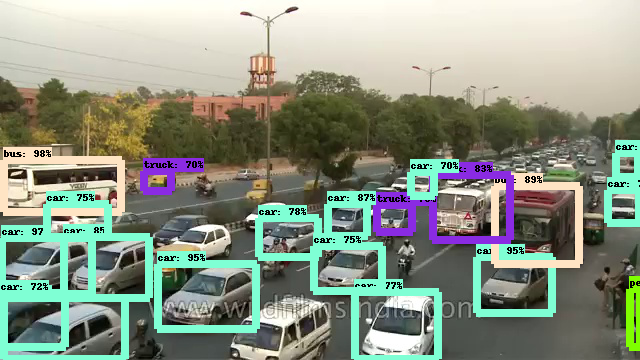

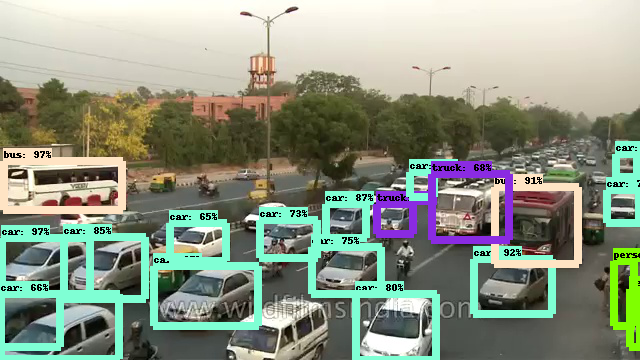

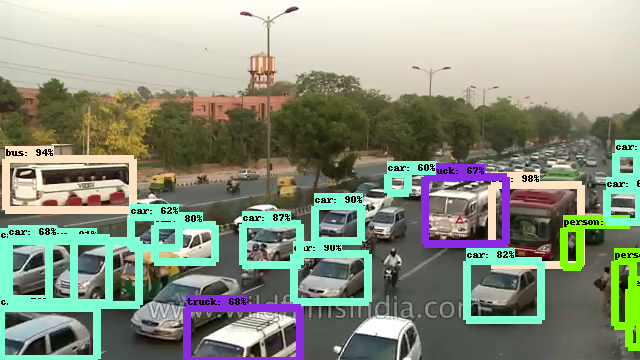

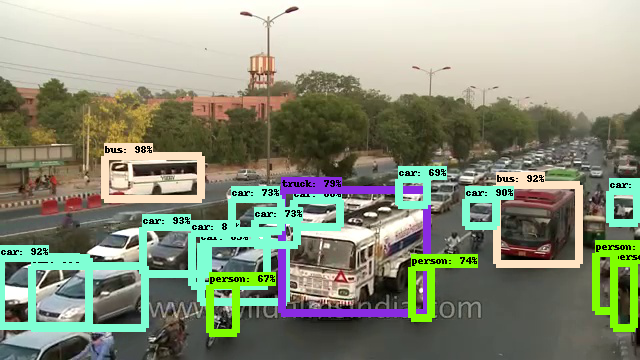

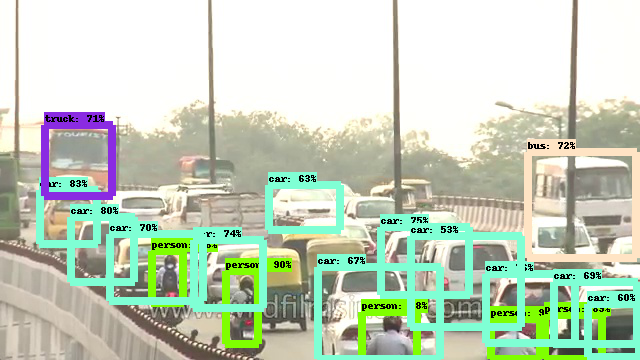

In [45]:
# Display first 5 images of detected objects
import glob

count=0
for image in sorted(glob.glob('*.jpg')):
    count+=1
    display(show_inference(detection_model, image))
    if count==5:
        break

In [43]:
# Detect the first 200 frames and store into a .gif file
import imageio

gif = []
count=0
for image in sorted(glob.glob('*.jpg')):
    count+=1
    gif.append(show_inference(detection_model, image))
    if count==200:
        break
imageio.mimsave('traffic.gif', gif)